Reference: https://gregorygundersen.com/blog/2019/08/13/bocd/ and https://arxiv.org/pdf/0710.3742

#### Setup

A `changepoint` is an underlying shift in the parameters that generate a data sequence (e.g. the mean of a Gaussian suddenly jumps). Here, we focus on the online task, that is, updating our belief as new observations are made.

To do this, after getting data point $x_t$, we track a latent run-length $r_t$ that counts how many data points have been generated by the current set of parameters (excluding last changepoint but including $x_t$), or how many time steps since the last changepoint

  - If no changepoint occurs at $t$, the run length grows by one $r_t = r_{t-1}+1$
  - If a changepoint occurs, we reset $r_t=0$ for the brand-new current run

See figure below for illustration

Technically, changepoints occur `between` data points. But since we need some way to encode $r_t=0$, so for simplicity, we just use the first data point of each segment (except for first segment, for convenience)

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as t_dist
from scipy.stats import norm
from scipy.special import logsumexp
from collections import namedtuple
import time
import json

# plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

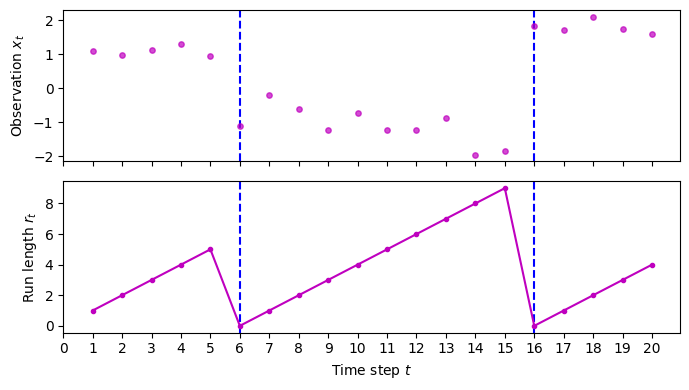

In [88]:
np.random.seed(42)

def generate_data(segment_lengths, segment_means, segment_stds):
    x_vals = []
    run_len = []
    for idx, (seg_len, mu, sigma) in enumerate(zip(segment_lengths, segment_means, segment_stds)):
        if idx == 0:
            x_vals.append(np.random.normal(mu, sigma, size=seg_len))
            run_len.append(np.arange(1, seg_len+1))
        else:
            x_vals.append(np.random.normal(mu, sigma, size=seg_len))
            run_len.append(np.arange(seg_len))

    x = np.concatenate(x_vals)
    r = np.concatenate(run_len)
    t = np.arange(1, len(x) + 1)

    change_points = np.cumsum(segment_lengths)[:-1] + 1

    return x, r, t, change_points

def plot_data(x, r, t, change_points):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 4))

    ax[0].scatter(t, x, c='m', s=15, alpha=0.7)
    for cp in change_points:
        ax[0].axvline(cp, c= 'b',ls='--',zorder=-1)
    ax[0].set_ylabel(r'Observation $x_t$')

    ax[1].plot(t, r, 'm.-')
    for cp in change_points:
        ax[1].axvline(cp, c= 'b',ls='--',zorder=-1)

    ax[1].set_ylabel(r'Run length $r_t$')
    ax[1].set_xlabel('Time step $t$')
    ax[1].set_xticks(np.arange(0, len(x)+1))

    fig.tight_layout()
    plt.show()

segment_lengths = [5, 10, 5]
segment_means = [1,  -1., 2]
segment_stds = [0.2, 0.5, 0.3]

x, r, t, change_points = generate_data(segment_lengths, segment_means, segment_stds)

plot_data(x, r, t, change_points)

We want to recursively update full run length `posterior` $p(r_t|x_{1:t})$ after receiving new data $x_t$
  - this is a discrete distribution of $t+1$ possible outcomes

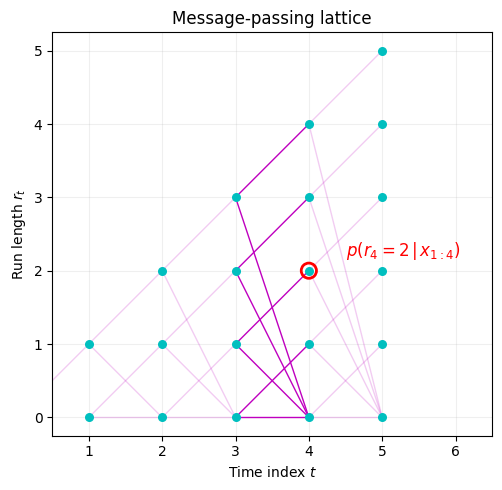

In [89]:
T = 5

nodes = []
edges = []

for t in range(1, T + 1):
    for r in range(0, t + 1):
        nodes.append((t, r))
        if r > 0:
            edges.append(((t - 1, r - 1), (t, r)))
        if t < T:
            edges.append(((t, r), (t + 1, 0)))

fig_1, ax_1 = plt.subplots(figsize=(7, 5))

for (x0, y0), (x1, y1) in edges:
    if x0 != 3:
        ax_1.plot([x0, x1], [y0, y1], c='m', lw=1, alpha=0.2)
    else:
        ax_1.plot([x0, x1], [y0, y1], c='m', lw=1)

x_nodes, y_nodes = zip(*nodes)
ax_1.scatter(x_nodes, y_nodes, c='c', s=30, zorder=2)

ax_1.scatter([4], [2], s=120, fc='none',
           ec='r', lw=2, zorder=3)

ax_1.text(
    4.5, 2.2,
    r'$p(r_{4}={2}\,|\,x_{{1:{4}}})$',
    c='r', fontsize=12, fontweight='bold'
)

ax_1.set_xlabel('Time index $t$')
ax_1.set_ylabel('Run length $r_t$')
ax_1.set_xlim(0.5, T + 1.5)
ax_1.set_aspect('equal')
ax_1.grid(True, alpha=0.2)

ax_1.set_title('Message-passing lattice')
fig_1.tight_layout()
plt.show()

#### Run length posterior

To compute `run length posterior`, we use the expression of conditional probability

$$\begin{align*}
p(r_t|x_{1:t})&=\frac{p(r_t, x_{1:t})}{\sum_{r_{t'}}p(r_{t'},x_{1:t})}
\end{align*}$$

We express the joint in a `recursive` manner

$$\begin{align*}
p(r_t, x_{1:t})&=\sum_{r_{t-1}}p(r_t, r_{t-1}, x_t, x_{1:t-1}) \\
&=\sum_{r_{t-1}}p(r_t, x_t | r_{t-1},  x_{1:t-1})p(r_{t-1}, x_{1:t-1})\\
&=\sum_{r_{t-1}}p(x_t|r_t, r_{t-1}, x_{1:t-1})p(r_t|r_{t-1}, x_{1:t-1})p(r_{t-1}, x_{1:t-1}) \\
& \text{assumption: } x_t \text{ does not depend on } r_t \\
& \text{assumption: } r_t \text{ conditionally independent of } x_{1:t-1} \\
&=\sum_{r_{t-1}}p(x_t|r_{t-1}, x_{1:t-1})p(r_t|r_{t-1})p(r_{t-1}, x_{1:t-1})\\
&=\boxed{\sum_{r_{t-1}}p(x_t|r_{t-1}, x_{t-1}^{(r)})p(r_t|r_{t-1})p(r_{t-1}, x_{1:t-1})\,}\\
\end{align*}$$

Therefore, the joint at step $t$, $p(r_t, x_{1:t})$, depends on predictive $p(x_t|r_{t-1}, x_{t-1}^{(r)})$ and joint $p(r_{t-1}, x_{1:t-1})$ at step $t-1$ plus a changepoint prior $p(r_t|r_{t-1})$

The predictive here is computed after $x_t$ is observed, so it acts like `likelihood`

It is noted from derivation above that once we set the initial joint $p(r_0)$, what remains to do is to efficiently compute `changepoint prior` and update `predictive`

#### Changepoint prior

To compute the `changepoint prior` $p(r_t|r_{t-1})$, we define the following functions

  - $f(\tau)$: prior probability that changepoint occurs at the $\tau$th data point
  - $S(\tau)$: survival function that changepoint occurs at the $\tau$th data point or later
  - $H(\tau)=f(\tau)/S(\tau)$: hazard function that `conditioned` on having survived through the $(\tau-1)$th data point, the probability that changepoint occurs at the $\tau$th data point

Therefore, the changepoint prior is a discrete probability distribution of two states

$$p(r_t|r_{t-1})=\left\{\begin{array}{ll}H(r_{t-1}+1) & r_t=0 \\ 1-H(r_{t-1}+1) & r_t=r_{t-1}+1\end{array}\right.$$

#### Conjugacy

One efficient way of computing `predictive` leverages conjugate model

Assume we have observations $D$, model parameters $\eta$ and hyperparameters $\nu$. Then the prior predictive distribution marginalized over parameters can be written as

$$p(x|\nu)=\int p(x|\eta)p(\eta |\nu)d\eta$$

where $p(x|\eta)$ is `predictive model` given parameters and $(\eta |\nu)$ is the prior of `parameters`

This is called `prior predictive distribution` because this is the prediction `before` we observe any data (that is, $D$ is not taken into account)

Similarly, we can write `posterior predictive distribution` as

$$
\begin{align*}
p(x|D, \nu)&=\int p(x|\eta)p(\eta |D, \nu)d\eta \\
\end{align*}
$$

A wonderful property of `conjugate` model is that the prior distribution and posterior distribution are of the same form. Therefore, if the prior and posterior of parameter are `conjugate w.r.t. certain likelihood function`, then we have

$$p(\eta|D, \nu) = p(\eta | \nu')$$

and

$$
\begin{align*}
p(x|D, \nu)&=\int p(x|\eta)p(\eta |D, \nu)d\eta \\
&=\int p(x|\eta)p(\eta |\nu')d\eta\\
&=p(x|\nu')
\end{align*}
$$

That is, the posterior predictive distribution is in the `same form` as the prior predictive with only changed hyperparameters $\nu'$

This allows us to bypass the whole integration thing provided that we can compute $\nu'$

##### Posterior of parameters in Gaussian

As an example, consider a Gaussian distribution with parameter $\mu$ and `fixed` variance $\sigma^2$, where $\mu$ is determined by two hyperparameters $\mu_0$ and $\sigma_0^2$, or with `prior` $\mu \sim N(\mu_0, \sigma_0^2)$

If we have $n$ data points $x_{1:n}$, we can write out the `likelihood`

$$
\begin{align*}L(x_{1:n}|\mu, \sigma^2)&=\prod_{i=1}^n p(x_i|\mu) \\
&=\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n \exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^n(x_i-\mu)^2\right]
\end{align*}$$

We can now write the `joint`

$$
\begin{align*}
p(x_{1:n}, \mu) &= \frac{1}{\sqrt{2\pi \sigma_0^2}}\exp\left[-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2\right]\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n \exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^n(x_i-\mu)^2\right]\\
&\propto \exp\left[-\frac{1}{2\sigma_0^2}\left(\mu^2-2\mu \mu_0+\mu_0^2\right)-\frac{1}{2\sigma^2}\sum_{i=1}^n\left(x_i^2-2x_i\mu+\mu^2\right)\right]\\
&=\exp \left[-\frac{\mu^2}{2\sigma_0^2}+\frac{\mu\mu_0}{\sigma_0^2}-\frac{\mu_0^2}{2\sigma_0^2}-\frac{1}{2\sigma^2}\sum_{i=1}^n x_i^2 +\frac{\mu}{\sigma^2}\sum_{i=1}^nx_i -\frac{\mu^2}{2\sigma^2}n\right] \\
&\propto \exp\left[-\frac{\mu^2\sigma^2+\mu^2\sigma_0^2n}{2\sigma_0^2\sigma^2}+\frac{\mu\mu_0\sigma^2+\mu\sigma_0^2\sum_{i=1}^nx_i}{\sigma_0^2\sigma^2}\right] \\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left((\sigma^2+\sigma_0^2n)\mu^2-2(\mu_0\sigma^2+\sigma_0^2\sum_{i=1}^nx_i)\mu\right)\right]\\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left(a\mu^2+b\mu+c\right)\right] \\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left(a(\mu-d)^2+e\right)\right]\\
a&=\sigma^2+\sigma_0^2n \\
d&=-\frac{b}{2a}=\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\\
e&=c-\frac{b^2}{4a}=-\frac{(\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i)^2}{\sigma^2+\sigma_0^2n} \\
&=\exp\left[-\frac{1}{2\sigma_0^2\sigma^2}\left((\sigma^2+\sigma_0^2n)\left(\mu-\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\right)^2-\frac{(\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i)^2}{\sigma^2+\sigma_0^2n}\right)\right] \\
&\propto \exp\left[-\frac{\sigma^2+\sigma_0^2n}{2\sigma_0^2\sigma^2}\left(\mu-\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\right)^2\right]
\end{align*}
$$

Using Bayes' rule, we know that `posterior` is proportional to this joint and therefore

$$p(\mu|x_{1:n})\propto \exp\left[-\frac{\sigma^2+\sigma_0^2n}{2\sigma_0^2\sigma^2}\left(\mu-\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n}\right)^2\right]$$

which is a Gaussian distribution as well

The posterior `variance` is

$$\sigma_n^2 = \left[\frac{\sigma_0^2\sigma^2}{\sigma^2+\sigma_0^2}\right]^2$$

or

$$
\begin{align*}
\frac{1}{\sigma_n^2} &=\frac{\sigma^2+\sigma_0^2n}{\sigma_0^2\sigma^2} \\
&=\frac{\sigma^2}{\sigma_0^2\sigma^2}+\frac{\sigma_0^2}{\sigma^2\sigma_0^2}n \\
&=\frac{1}{\sigma_0^2}+\frac{1}{\sigma^2}n
\end{align*}
$$

and

$$\sigma_n^2 =\frac{\sigma_0^2\sigma^2}{\sigma^2+\sigma_0^2n}= \frac{1}{\frac{1}{\sigma_0^2}+\frac{1}{\sigma^2}n}$$

The posterior `mean` is

$$
\begin{align*}
\mu_n &= \frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+\sigma_0^2n} \\
&=\frac{\sigma^2}{\sigma^2+\sigma_0^2n}\mu_0+\frac{\sigma_0^2}{\sigma^2+\sigma_0^2n}\sum_{i=1}^nx_i \\
&=\sigma_n^2\left(\frac{\mu_0}{\sigma_0^2}+\frac{1}{\sigma^2}\sum_{i=1}^nx_i\right)
\end{align*}$$

Recall that $\frac{1}{n}\sum_{i=1}^nx_i$ is the `maximum likelihood` estimate of $\mu$

So the posterior mean is a weighted sum of prior mean $\mu_0$ and the ML estimate $\mu_{ML}$


##### Derivation from perspective of optimization

Because the posterior $p(\mu| x_{1:n})$ is Gaussian, therefore, the center of posterior density is also the maximum-a-posteriori (MAP) estimate of the mean $\mu_n=\mu_{\text{MAP}}$

If we just want to get this MAP estimate, we can take derivative of $\log p(\mu|x_{1:n})$ or for calculation, the log of joint $\log p(x_{1:n}, \mu)$ (since the difference in constant vanishes after differentiation)

$$
\begin{align*}
\frac{d}{d\mu}\log p(x_{1:n}, \mu)&=\frac{d}{d\mu}\left[-\frac{1}{2\sigma_0^2}(\mu-\mu_0)^2-\frac{1}{2\sigma^2}\sum_{i=1}^n(x_i-\mu)^2+\text{const.}\right] \\
&=\frac{d}{d\mu}\left[-\frac{1}{2\sigma_0^2}(\mu^2-2\mu\mu_0)-\frac{1}{2\sigma^2}\left(n\mu^2-2\mu\sum_{i=1}^nx_i\right)+\text{const.}\right] \\
& \text{group } \mu^2 \text{ and } \mu \\
&=\frac{d}{d\mu}\left[-\frac{\sigma^2+n\sigma_0^2}{2\sigma_0^2\sigma^2}\mu^2+\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma_0^2\sigma^2}\mu +\text{const.}\right]
\end{align*}
$$

and set to zero, we have

$$\frac{\sigma^2+n\sigma_0^2}{\sigma_0^2\sigma^2}\mu=\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma_0^2\sigma^2} $$

Solve for the MAP estimate

$$\mu_{\text{MAP}}=\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+n\sigma_0^2}$$

which is the same as the posterior mean $\mu_n$ we get earlier

Both approaches, taking the derivative or completing the square, are mathematically identical

The latter just skips writing the derivative because the result can be read off immediately once the quadratic is centered

Same can be done for posterior variance

Since the posterior is Gaussian, we know

$$\log p(\mu|x_{1:n})=-\frac{1}{2\sigma_n^2}(\mu-\mu_n)^2+\text{const.}$$

Take second derivative w.r.t. $\mu$

$$
\begin{align*}
\left.\frac{d^2}{d\mu^2}\log p(\mu|x_{1:n})\right|_{\mu=\mu_n}
&=\left.\frac{d^2}{d\mu^2}\log p(\mu,x_{1:n})\right|_{\mu=\mu_n}\\
&=-\frac{1}{\sigma_n^2} \\
&=-\frac{\sigma^2+n\sigma_0^2}{\sigma_0^2\sigma^2}
\end{align*}
$$

and we get posterior variance as before

$$\sigma_n^2 =\frac{\sigma_0^2\sigma^2}{\sigma^2+n\sigma_0^2}$$

#### Exponential family

More generally, it is the exponential family that is of interest

Standard distributions can be cast into a canonical form (we can think of it as `likelihood`)

$$p(x|\eta)=h(x)g(\eta)\exp \left[\eta^T u(x)\right]$$

where
  - $h(x)$ is `underlying measure` carrying every factor that does not involve $\eta$
  - $u(x)$ is sufficient-statistic of `data`
  - $\eta$ is `natural-parameter`
  - $g(\eta)$ is normalizer

$$\begin{align*}
g(\eta) \int h(x) \exp\left[\eta^T u(x)\right]dx=1
\end{align*}$$

##### Sufficient statistic

For data $x_{1:n}$, the idea of sufficient statistic is that we can use

$$\sum_{i=1}^n u(x_{i})$$

to compute maximum likelihood estimate of natural parameters

Use canonical form, we can write the log-likelihood as

$$
\begin{align*}
\log p(x_{1:n}|\eta)&=\log \prod_{i=1}^n p(x_i|\eta)\\
&=\log \left[\left(\prod_{i=1}^nh(x_i)\right)g(\eta)^n\exp\left(\eta^T\sum_{i=1}^nu(x_i)\right)\right]\\
&=\log \left(\prod_{i=1}^nh(x_i)\right)+n\log g(\eta)+\eta^T\sum_{i=1}^nu(x_i)
\end{align*}
$$

Take gradient w.r.t. $\eta$ and set to zero

$$\nabla n\log g(\eta_{\text{ML}})+\sum_{i=1}^nu(x_i)=0$$

or

$$-\nabla \log g(\eta_{\text{ML}}) = \frac{1}{n}\sum_{i=1}^nu(x_i)$$

Note that since sufficient statistic is a running sum, we can compute it `incrementally` as new data arrives

##### Moments through differentiation

Denote log normalizer

$$A(\eta)=-\log g(\eta)=\log \int h(x)\exp \left[\eta^Tu(x)\right]dx$$

Take gradient w.r.t. $\eta$

$$\nabla A(\eta)=\frac{1}{Z(\eta)}\nabla Z(\eta)$$

where

$$Z(\eta)=\exp[A(\eta)]=\int h(x) \exp\left[\eta^Tu(x)\right]dx$$

Under some mild condition, we can write

$$
\begin{align*}
\nabla Z(\eta)&=\int h(x)u(x)\exp\left[\eta^Tu(x)\right]dx \\
&=\int u(x)Z(\eta)\frac{h(x)\exp\left[\eta^Tu(x)\right]}{Z(\eta)}dx\\
& \text{the fraction is a density on }x\\
&=\mathbb{E}\left[Z(\eta)u(x)\right]\\
&=Z(\eta)\mathbb{E}\left[u(x)\right]
\end{align*}$$

Therefore

$$\nabla A(\eta)=\frac{1}{Z(\eta)}\nabla Z(\eta)=\mathbb{E}\left[u(x)\right]$$

##### Conjugate prior and posterior

For exponential family member, it has a conjugate `prior` of form

$$p(\eta|\chi, \nu)=f(\chi, \nu)g(\eta)^{\nu}\exp\left[\eta^T\chi\right]$$

where $\nu, \chi$ are hyperparameters and $f(\chi, \nu)$ depends on form of exponential family member

We can verify that `posterior` and `prior` are indeed of same form

$$
\begin{align*}
p(\eta|x_{1:n},\chi, \nu) &\propto p(x_{1:n}|\eta)p(\eta|\chi, \nu)\\
&=\left[\left(\prod_{i=1}^nh(x_i)\right)g(\eta)^n\exp\left(\eta^T\sum_{i=1}^nu(x_i)\right)\right]f(\chi, \nu)g(\eta)^{\nu}\exp\left[\eta^T\chi\right]\\
&=\left(\prod_{i=1}^nh(x_i)\right)f(\chi, \nu)g(\eta)^{n+\nu}\exp\left(\eta^T\left(\sum_{i=1}^nu(x_i)+\chi\right)\right)\\
&\propto g(\eta)^{n+\nu}\exp\left(\eta^T\left(\sum_{i=1}^nu(x_i)+\chi\right)\right)\\
\end{align*}
$$

So for posterior

$$\begin{align*}
\nu &= \nu_{\text{prior}}+n \\
\chi &= \chi_{\text{prior}}+\sum_{i=1}^nu(x_i) \\
\end{align*}$$

and

$$\begin{align*}
\nu_t &= \left\{\begin{array}{ll}\nu_{\text{prior}} & t=0 \\ \nu_{t-1}+1 & t>0\end{array}\right.\ \\
\chi_t &= \left\{\begin{array}{ll}\chi_{\text{prior}} & t=0 \\ \chi_{t-1}+u(x_{t}) & t>0\end{array}\right.\ \\
\end{align*}$$

It should be noted that neither natural parameter $\eta$ nor hyperparameters $\chi, \nu$ are necessarily the ones we are familier with (mean, variance)

When we translate back to the more familiar parameters, those same additions are still there, but they appear through whatever nonlinear transformation connects the two parameterizations

##### Posterior of parameters in Gaussian

Use Gaussian as example, with `both` mean and variance as parameters

$$
\begin{align*}
p(x|\mu, \sigma^2)&=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}(x-\mu)^2\right] \\
&=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}x^2+\frac{\mu}{\sigma^2}x-\frac{\mu^2}{2\sigma^2}\right]\\
&=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{\mu^2}{2\sigma^2}\right]\exp\left[\frac{\mu}{\sigma^2}x-\frac{1}{2\sigma^2}x^2\right]
\end{align*}
$$

By split like this, we can introduce sufficient statistic and natural parameter

$$u(x)=\begin{bmatrix}x \\ x^2\end{bmatrix}, \eta(\mu, \sigma^2)=\begin{bmatrix}\eta_1\\ \eta_2\end{bmatrix}=\begin{bmatrix}\frac{\mu}{\sigma^2}\\ -\frac{1}{2\sigma^2}\end{bmatrix}$$

In addition

$$h(x)=\frac{1}{\sqrt{2\pi}}, g(\eta)=\frac{1}{\sigma}\exp\left[-\frac{\mu^2}{2\sigma^2}\right]$$

Notice that

$$\frac{1}{\sigma}=\sqrt{-2\eta_2}$$

and

$$-\frac{\mu^2}{2\sigma^2}=\frac{\eta_1^2}{4\eta_2}$$

we can rewrite the normalizer as

$$g(\eta)=\sqrt{-2\eta_2}\exp \left[\frac{\eta_1^2}{4\eta_2}\right]$$

For simplicity, we will go through whole process of getting posterior of parameters using Gaussian example of `fixed` variance

Remember, the `ultimate` goal is to obtain posterior of parameters given data $\mu|x_{1:n}$

We know that doing this is easier for exponential family in natural parameter space than in orginal parameter space, so in short, we do the following steps

  1. identify `conversion` between original `parameter` $\mu$ and natural parameter $\eta$ (by writing density $p(x|\mu)$ in canonical form)
  2. write canonical form `conjugate prior` (which is in natural parameter space with natural hyperparameters, $p(\eta|\chi, \nu)$)
  3. identify `conversion` between original `hyperparameters` and natural hyperparameters, usually done in two substeps
    - 3.1 obtain conjugate prior in `original` parameter space but still expressed in `natural` hyperparameters, $p(\mu|\chi, \nu)$, using conversion in #1
    - 3.2 compare conjugate prior in original parameter space with original hyperparameters and natural hyperparameters
  4. obtain `posterior` in original parameter space expressed in natural hyperparameters (obtained in #3.1), by replacing natural hyperparameters with additively updated values $p(\mu|\chi+\sum u(x_i), \nu+n)$
  5. obtain `posterior` in original parameter space expressed in original hyperparameters, using conversion in #3.2

With fixed variance $\sigma^2$, we can split `density` (expressed in `original` parameters) as

$$
\begin{align*}
p(x|\mu, \sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}x^2\right]\exp\left[-\frac{\mu^2}{2\sigma^2}\right]\exp\left[\frac{\mu}{\sigma^2}x\right]
\end{align*}
$$

We can `identify` natural parameters, sufficient statistic, normalizer and underlying measure, expressed in `original` parameters

$$
\begin{align*}
\eta &= \frac{\mu}{\sigma^2}\\
u(x) & = x \\
h(x) &= \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2\sigma^2}x^2\right]\\
g(\eta) & =\exp\left[-\frac{\mu^2}{2\sigma^2}\right]=\exp\left[-\frac{\sigma^2\eta^2}{2}\right]\\
\end{align*}
$$

in order to put everything into canonical form

$$p(x|\eta)=h(x)g(\eta)\exp \left[\eta^T u(x)\right]$$


Then, write canonical form `conjugate prior` (in `natural` parameter space, with `natural` hyperparameters $\chi, \nu$)

$$p(\eta|\chi, \nu)=f(\chi, \nu)g(\eta)^{\nu}\exp\left[\eta^T\chi\right]$$

In the case of fixed variance, we plug in $g(\eta)$ and since $f(\chi, \nu)$ does not depend on $\eta$, we have

$$p(\eta|\chi, \nu)\propto \exp \left[-\frac{\nu\sigma^2}{2}\eta^2+\chi\eta\right] \sim N\left(\eta;\frac{\chi}{\nu\sigma^2},\frac{1}{\nu\sigma^2}\right)$$

Write out conjugate prior of `original` parameters $\mu$, with `natural` hyperparameters, using the conversion between original and natural parameters $\mu=\sigma^2\eta$

$$\mu \sim N\left(\mu; \frac{\chi}{\nu}, \frac{\sigma^2}{\nu}\right)=N(\mu;\mu_0, \sigma_0^2)$$

Identify `conversion` between original hyperparameters ($\mu_0, \sigma_0^2)$ and natural hyperparameters $\chi, \nu$

$$
\begin{align*}
\mu_0&=\frac{\chi}{\nu}\\
\sigma_0^2&=\frac{\sigma^2}{\nu}
\end{align*}
$$

Subscript 0 indicating the mean of prior (that is, taking zero observation into account)

We can also have

$$
\begin{align*}
\chi&=\mu_0\nu\\
\nu&=\frac{\sigma^2}{\sigma_0^2}
\end{align*}
$$

which will be useful when converting from $\chi, \nu$ to $\mu_0, \sigma_0,\sigma$

For `posterior`, which has same form as conjugate prior

Optionally, we can write out posterior of `natural` parameters $\eta$ using additively updated `natural` hyperparameters $\chi', \nu'$

$$\begin{align*}
&p(\eta|x_{1:n})\sim N\left(\eta;\frac{\chi'}{\nu'\sigma^2}, \frac{1}{\nu'\sigma^2}\right) \\
& \text{since }
\nu' = \nu+n,
\chi' = \chi+\sum_{i=1}^nu(x_i) \\
&p(\eta|x_{1:n})\sim N\left(\eta;\frac{\chi+\sum_{i=1}^nu(x_i)}{(\nu+n)\sigma^2}, \frac{1}{(\nu+n)\sigma^2}\right) \\
\end{align*}$$

Or we can directly use posterior of `original` parameters with `natural` hyperparameters

$$\mu \sim N\left(\mu; \frac{\chi}{\nu}, \frac{\sigma^2}{\nu}\right)\rightarrow\mu|x_{1:n} \sim N\left(\mu;\frac{\chi+\sum_{i=1}^nu(x_i)}{\nu+n}, \frac{\sigma^2}{\nu+n}\right) $$

Plug in conversion between original hyperparameters and natural hyperparameters, we can obtain the posterior of original parameters using original hyperparameters (and data points)

$$\begin{align*}
p(\mu|x_{1:n})\sim N\left(\mu;\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+n\sigma_0^2},\frac{\sigma_0^2\sigma^2}{\sigma^2+n\sigma_0^2}\right)=N(\mu; \mu_n, \sigma_n^2)
\end{align*}$$

which is the same as derived earlier using completion of square or optimization method, but without much calculation needed

#### Predictive

In our case, we will model the `predictive` at time $t$ using exponential family

$$p(x_t|r_{t-1}=r, x_{t-1}^{(r)}) = p(x_t|\nu_{t-1}^{(r)}, \chi_{t-1}^{(r)})$$

$\nu_{t-1}^{(r)}, \chi_{t-1}^{(r)}$ denote hyperparameters updated at conclusion of step $t-1$ where $r_{t-1}=r$

This is step to obtain the `run length posterior`

$$\begin{align*}
p(r_t| x_{1:t})\propto p(r_t, x_{1:t})=\sum_{r_{t-1}}p(x_t|r_{t-1}, x_{t-1}^{(r)})p(r_t|r_{t-1})p(r_{t-1}, x_{1:t-1})
\end{align*}$$

The simplest case is Gaussian with `fixed` variance $\sigma^2$

$$
\begin{align*}
\mu &\sim N(\mu_0, \sigma_0^2)\\
x &\sim N(\mu, \sigma^2)\\
\end{align*}
$$

Once we know $\mu_{t-1}, \sigma_{t-1}^2$, we have

$$p(x_t|r_{t-1}=r, x_{t-1}^{(r)}) \sim N(x_t|\mu_{t-1}, \sigma_{t-1}^2+\sigma^2)
$$

##### Incremental hyperparameter update

Base on the setup, at time $t$, we are going to, `after observing` $x_t$
  - update hyperparameters corresponding $t$ possible run lengths at $t-1$, that is, $r_{t-1}^{l-1}\rightarrow r_{t}^{l}, (l=1,...,t)$, for non-changepoint cases
  - add hyperparameters for $r_t^0$ (changepoint case), which would always be the prior $\mu_0, \sigma_0$ (drop square for variance for clarity)

For example

At $t=1$ (only one possible run length at $t=0$), we update

$$\mu_0^0, \sigma_0^0 \rightarrow \mu_1^1, \sigma_1^1$$

while adding prior $\mu_1^0, \sigma_1^0$

At $t=2$ (two possible run lengths at $t=1$), we update

$$\mu_1^0, \sigma_1^0 \rightarrow \mu_2^1, \sigma_2^1, \,\mu_1^1, \sigma_1^1 \rightarrow \mu_2^2, \sigma_2^2$$

while adding prior $\mu_2^0, \sigma_2^0$

and so on...

From above we know the posterior of $\mu$ after $x_{1:n}$ is

$$\begin{align*}
p(\mu|x_{1:n})\sim N\left(\mu;\frac{\sigma^2\mu_0+\sigma_0^2\sum_{i=1}^nx_i}{\sigma^2+n\sigma_0^2},\frac{\sigma_0^2\sigma^2}{\sigma^2+n\sigma_0^2}\right)=N(\mu; \mu_n, \sigma_n^2)
\end{align*}$$

and

$$
\begin{align*}
\frac{1}{\sigma_n^2}&=\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\\
\mu_n&=\sigma_n^2\left(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^nx_i}{\sigma^2}\right)
\end{align*}$$

We can make this an `incremental` process, just swap $\sigma_0, \mu_0, \sum_{i=1}^nx_i$ with $\sigma_{n-1}, \mu_{n-1}, x_n$

The variance part is

$$\frac{1}{\left(\sigma_{t}^{l}\right)^2}=\frac{1}{\left(\sigma_{t-1}^{l-1}\right)^2}+\frac{1}{\sigma^2}, l=1,...,t$$

$$
\begin{matrix}
& l=0  & l=1 & l=2 & l=3 & \cdots \\
t=0 & \frac{1}{\left(\sigma_0^0\right)^2}=\frac{1}{\left(\sigma_0\right)^2} \\
t=1 & \frac{1}{\left(\sigma_1^0\right)^2}=\frac{1}{\left(\sigma_0\right)^2} & \frac{1}{\left(\sigma_1^1\right)^2}=\frac{1}{\left(\sigma_0\right)^2}+\frac{1}{\sigma^2}\\
t=2 & \frac{1}{\left(\sigma_2^0\right)^2}=\frac{1}{\left(\sigma_0\right)^2} & \frac{1}{\left(\sigma_2^1\right)^2}=\frac{1}{\left(\sigma_0\right)^2}+\frac{1}{\sigma^2} & \frac{1}{\left(\sigma_2^2\right)^2}=\frac{1}{\left(\sigma_0\right)^2}+\frac{2}{\sigma^2}\\
t=3 & \frac{1}{\left(\sigma_3^0\right)^2}=\frac{1}{\left(\sigma_0\right)^2} & \frac{1}{\left(\sigma_3^1\right)^2}=\frac{1}{\left(\sigma_0\right)^2}+\frac{1}{\sigma^2} & \frac{1}{\left(\sigma_3^2\right)^2}=\frac{1}{\left(\sigma_0\right)^2}+\frac{2}{\sigma^2} & \frac{1}{\left(\sigma_3^3\right)^2}=\frac{1}{\left(\sigma_0\right)^2}+\frac{3}{\sigma^2}\\
\vdots \\
\end{matrix}$$

The mean part is

$$\mu_{t}^{l} = \left(\sigma_{t}^{l}\right)^2\left(\frac{\mu_{t-1}^{l-1}}{\left(\sigma_{t-1}^{l-1}\right)^2}+\frac{x_t}{\sigma^2}\right), l=1,...,t$$

$$
\begin{matrix}
& l=0 & l=1 & l=2 & l=3 & \cdots\\
t=0 & \mu_0^0=\mu_0 \\
t=1 & \mu_1^0=\mu_0 & \mu_1^1=(\sigma_{1}^1)^2\left(\frac{\mu_0^0}{\left(\sigma_0^0\right)^2}+\frac{x_1}{\sigma^2}\right) \\
t=2 & \mu_2^0=\mu_0 & \mu_2^1=(\sigma_{2}^1)^2\left(\frac{\mu_1^0}{\left(\sigma_1^0\right)^2}+\frac{x_2}{\sigma^2}\right) & \mu_2^2=(\sigma_{2}^2)^2\left(\frac{\mu_1^1}{\left(\sigma_1^1\right)^2}+\frac{x_2}{\sigma^2}\right)\\
t=3 & \mu_3^0=\mu_0 & \mu_3^1=(\sigma_{3}^1)^2\left(\frac{\mu_2^0}{\left(\sigma_2^0\right)^2}+\frac{x_3}{\sigma^2}\right) & \mu_3^2=(\sigma_{3}^2)^2\left(\frac{\mu_2^1}{\left(\sigma_2^1\right)^2}+\frac{x_3}{\sigma^2}\right) & \mu_3^3=(\sigma_{3}^3)^2\left(\frac{\mu_2^2}{\left(\sigma_2^2\right)^2}+\frac{x_3}{\sigma^2}\right)\\
\vdots
\end{matrix}$$

#### Example: Gaussian with changing mean and fixed variance

So, putting everything together

We begin with $\mu_0, \sigma_0^2$ at $t=0$, and $p(r_0, x_0=\emptyset)=1$

Start $t=1$
  - Get $x_t$
  - Calculate $p(x_t|r_{t-1}=r, x_{t-1}^{(r)})$ with $\mu_{t-1}^{(l-1)}, \sigma_{t-1}^{(l-1)}, l=1,...,t$
    - Total of $t$ calculations, corresponding to run length $r_t=1,...,t$
  - Update run length posteior for all $r_t=0,...,t$
  $$\begin{align*}
p(r_t| x_{1:t})\propto p(r_t, x_{1:t})=\sum_{r_{t-1}}p(x_t|r_{t-1}, x_{t-1}^{(r)})p(r_t|r_{t-1})p(r_{t-1}, x_{1:t-1})
\end{align*}$$
    - Here for $r_t=l, l=1,...,t$, $r_{t-1}$ can only be $l-1$, so the summation goes away
    - Summation is needed for $r_t=0$ though
  - Update $\mu_{t-1}^{(l-1)}, \sigma_{t-1}^{(l-1)} \rightarrow \mu_{t}^{(l)}, \sigma_{t}^{(l)}, l=1,...,t$, append $\mu_t^{(0)}, \sigma_t^{(0)}$ as prior
  - $t\leftarrow t+1$
  - Repeat

In [90]:
hyper_param_inst = namedtuple('Hyper_parameter', ['mu', 'var'])

def log_pred_prob(hyper_param, x_t, obs_var):
    # predictive probability given x_t using hyperparameters from step t-1
    pred_mean = hyper_param.mu
    pred_std = (hyper_param.var + obs_var) ** 0.5
    return norm.logpdf(x_t, pred_mean, pred_std)

def update_hyper_param(hyper_param, x_t, obs_var):
    # update for hyperparameters after run length posterior
    new_var = 1.0 / (1.0 / hyper_param.var + 1.0 / obs_var)
    new_mu = new_var * (hyper_param.mu / hyper_param.var + x_t / obs_var)
    return hyper_param_inst(mu=new_mu, var=new_var)

In [91]:
def cp_detection(
    data_x,
    num_steps,
    hyper_param_rt,
    prior_hyper_param,
    var_obs,
    inv_hazard,
    pruning_eps,
    use_prior_for_cp=True,
    ):

    # joint p(r, x) at t=0, only one possible value
    joint_prob = np.array([1.])
    run_lengths = np.array([0]) # track actual run lengths of entries after pruning
    log_joint_prob = np.log(joint_prob)
    hist_len_rt_after_pruning = [len(run_lengths)]

    # allocate a lower-triangular matrix to store run length posterior
    post_rt = np.zeros((num_steps+1, num_steps+1))
    post_rt[0, 0] = 1.

    # simplest hazard function
    def hazard(rt):
        return np.ones_like(rt)/inv_hazard

    for t in range(1, num_steps+1):
        # hyper_param_rt, run_lengths, log_joint_prob all pruned to eff_len after t-1

        # get data
        x_t = data_x[t-1]

        # get predictive probability of x_t
        log_pred_prob_x_t = np.array([log_pred_prob(hp, x_t, var_obs) for hp in hyper_param_rt]) # (eff_len,)

        # get run length posterior
        log_joint_prob_growth = log_pred_prob_x_t + np.log1p(-hazard(run_lengths)) + log_joint_prob # (eff_len,)
        new_run_lengths = run_lengths + 1
        if use_prior_for_cp:
            log_pred_prob_cp = log_pred_prob(prior_hyper_param, x_t, var_obs)
            log_joint_prob_changepoint = log_pred_prob_cp + logsumexp(np.log(hazard(run_lengths)) + log_joint_prob)
        else:
            log_joint_prob_changepoint = logsumexp(log_pred_prob_x_t + np.log(hazard(run_lengths)) + log_joint_prob)
        log_joint_prob = np.insert(log_joint_prob_growth, 0, log_joint_prob_changepoint) # (eff_len+1,)
        run_lengths = np.insert(new_run_lengths, 0, 0) # (eff_len+1,)

        # normalize joint to get posterior
        log_joint_prob -= logsumexp(log_joint_prob) # (eff_len+1,)

        # get rid of small joint probabilities which waste computation
        idx_keep = log_joint_prob > np.log(pruning_eps)+log_joint_prob.max() # (eff_len+1,)
        idx_keep[0] = True

        log_joint_prob = log_joint_prob[idx_keep] # (len(idx_keep),)
        run_lengths = run_lengths[idx_keep] # (len(idx_keep),)
        hist_len_rt_after_pruning.append(len(run_lengths))

        # propagate into cols corresponding to actual run length
        # here, the column of entry needs to match actual run length of the entry in log_joint_prob
        post_rt[t, run_lengths] = np.exp(log_joint_prob)

        # update hyperparameters
        new_hyper_param_rt = [prior_hyper_param] + [
            update_hyper_param(hp, x_t, var_obs)
            for hp, keep in zip(hyper_param_rt, idx_keep[1:]) if keep
        ] # only update and apeend hyper_param_rt entry that survives pruning
        hyper_param_rt = new_hyper_param_rt # (len(idx_keep),)

    return post_rt, hist_len_rt_after_pruning

In [92]:
def plot_cp_detection(x,
                      post_rt,
                      hist_len_rt_after_pruning,
                      r_true=None,
                      change_points=None,
                      alpha_min=1e-12):

    num_steps = len(x)
    t_axis = np.arange(1, num_steps + 1)

    ts, rs, probs = [], [], []

    for t in range(1, num_steps + 1):
        row = post_rt[t, :t + 1]
        # indices whose probability exceeds threshold
        idx_keep = np.where(row > alpha_min)[0]
        # add time step indices to ts (all =t for these points in this row)
        ts.extend([t] * len(idx_keep))
        # add run lengths (which are just indices) to these points
        rs.extend(idx_keep)
        # add probs to these points
        probs.extend(row[idx_keep])

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(14,10))

    ax[0].scatter(t_axis, x, c='m', s=15, alpha=0.7)
    if change_points is not None:
        for cp in change_points:
            ax[0].axvline(cp, color='b', ls='--', zorder=-1)
    ax[0].set_ylabel(r'Observation $x_t$')

    ax[1].scatter(ts, rs, c='c', s=15, alpha=probs,
                       label='Posterior $r_t$')
    if change_points is not None:
        for cp in change_points:
            ax[1].axvline(cp, color='b', ls='--', zorder=-1)
    ax[1].set_ylabel(r'Run length $r_t$')
    ax[1].legend(loc='upper right')

    ax[2].plot(t_axis, hist_len_rt_after_pruning[1:], label='after pruning', lw=1.8)
    ax[2].plot(t_axis, t_axis+1, '--', label='no pruning')
    ax[2].set_ylabel(r'$\#$ effective run lengths')
    ax[2].set_xticks(np.arange(0, len(x) + 1, len(t_axis) // 10))
    ax[2].legend()

    plt.tight_layout()
    plt.show()

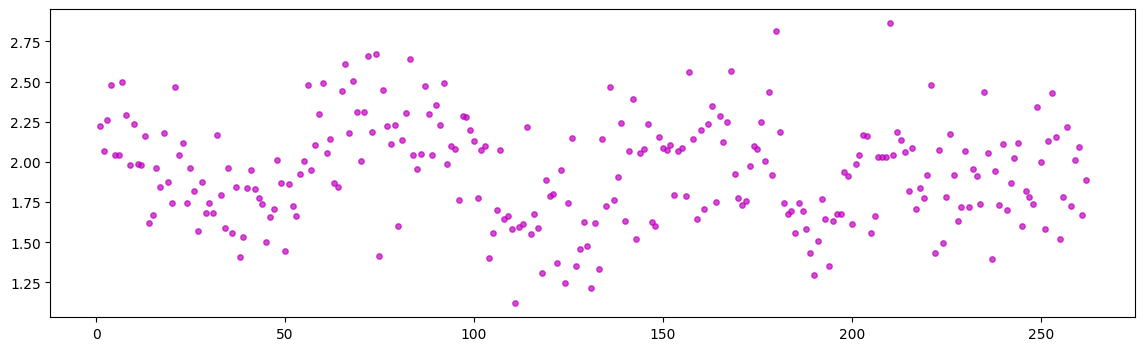

In [93]:
np.random.seed(42)

# generate data
segment_lengths = [25, 30, 48, 30, 50, 13, 66]
segment_means = [2.1, 1.8, 2.2, 1.6, 2, 1.6, 1.9]
segment_stds = [0.25, 0.2, 0.3, 0.25, 0.3, 0.2, 0.25]
data_x, data_r, _, data_cp = generate_data(
    segment_lengths,
    segment_means,
    segment_stds
    )
num_steps = sum(segment_lengths)

plt.figure(figsize=(14, 4))
plt.scatter(np.arange(1, num_steps + 1), data_x, c='m', s=15, alpha=0.7)
plt.show()

In [94]:
# hyperparameters
mu_prior = 1
var_prior = 1
hyper_param_rt = [hyper_param_inst(mu_prior, var_prior)] # list, corresponding to different r_t

# keep a copy of prior to be appended to hyperparameter list
prior_hyper_param = hyper_param_inst(mu_prior, var_prior)

"""
When prior is much broader than the "likelihood",
that makes the prior predictive quite forgiving and further
helps the algorithm notice a changepoint quickly.
If we make the prior narrower than the data likelihood
we will again slow down detection
"""

post_rt, hist_len_rt_after_pruning = cp_detection(
    data_x,
    num_steps,
    hyper_param_rt,
    prior_hyper_param,
    var_obs=0.05, # set this to smallest var to expect
    inv_hazard=20.,
    pruning_eps=1e-8,
    use_prior_for_cp=True,
    )

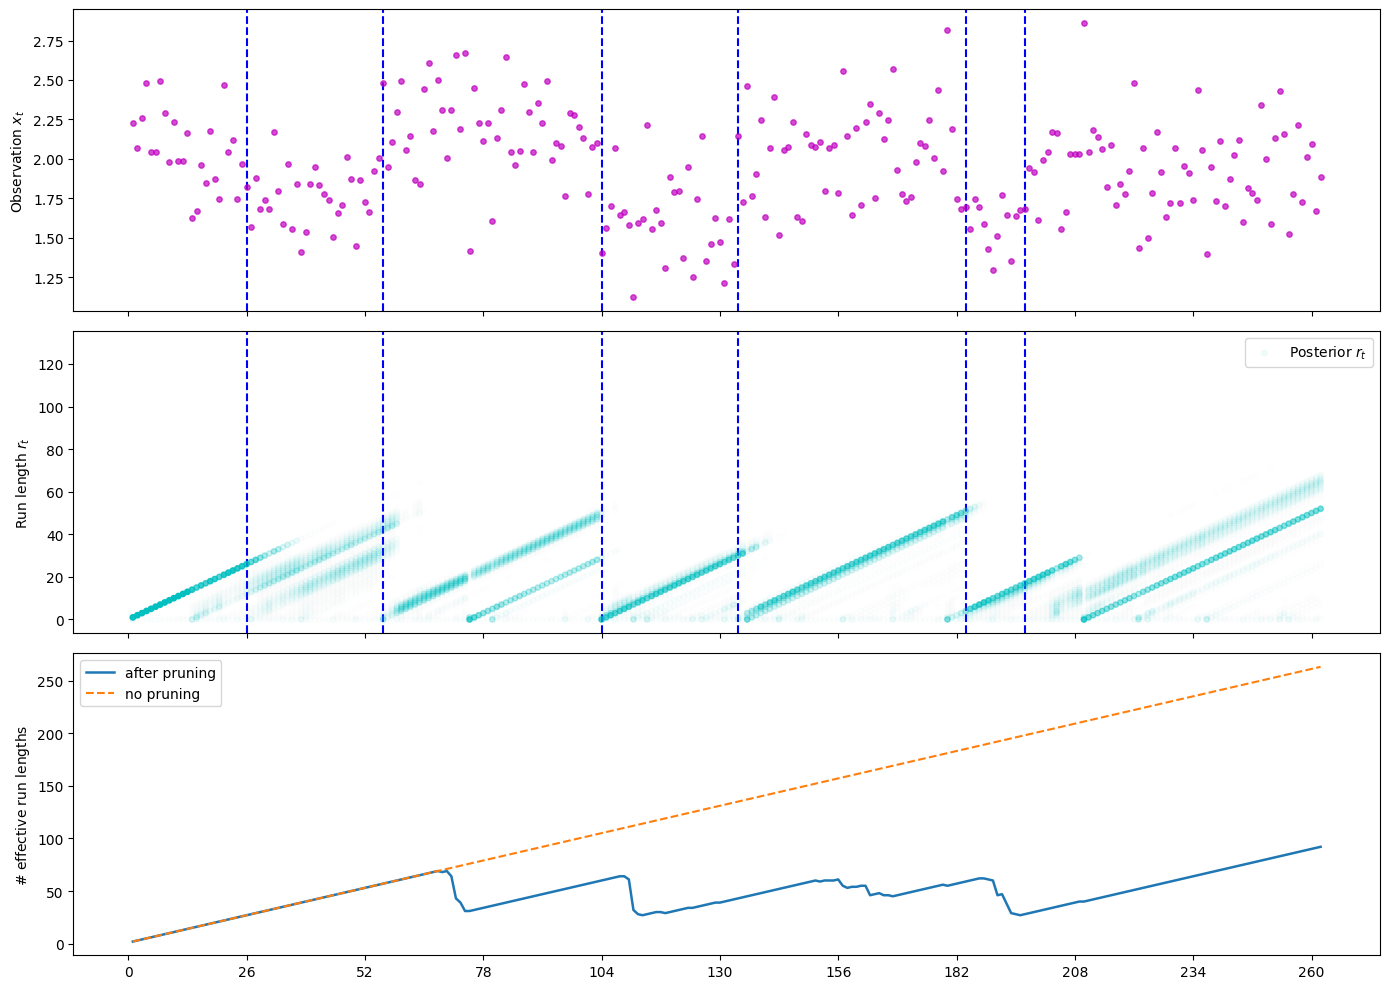

In [95]:
# print(np.argmax(post_rt[1:], axis=1))
plot_cp_detection(data_x, post_rt, hist_len_rt_after_pruning,
                   change_points=data_cp, r_true=data_r)

#### Example: Gaussian with changing mean and variance

Reference: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

For the scenario where both $\mu$ and $\sigma^2$ are changing in data, the `conjugate prior` for the Gaussian likelihood is Gaussian-gamma distribution, with $\lambda=\frac{1}{\sigma^2}$ for mathematical convenience

$$NG(\mu, \lambda; \mu_0, \kappa_0, \alpha_0, \beta_0)\sim N\left(\mu;\mu_0, (\kappa_0\lambda)^{-1}\right)Ga(\lambda;\alpha_0, \beta_0)$$

The `posterior` after receiving $x_{1:t}$ is

$$
\begin{align*}
p(\mu, \lambda| x_{1:t})&=NG(\mu,\lambda; \mu_t, \kappa_t, \alpha_t, \beta_t)\\
\mu_t&=\frac{\kappa_0\mu_0+\sum_{i=1}^tx_i}{\kappa_0+t} \\
\kappa_t&=\kappa_0+t\\
\alpha_t&=\alpha_0+\frac{t}{2}\\
\beta_t&=\beta_0+\frac{1}{2}\sum_{i=1}^t(x_i-\bar{x}_t)^2+\frac{\kappa_0t}{2(\kappa_0+t)}(\bar{x}_t-\mu_0)^2
\end{align*}
$$

We can revise it to do one-step update

The `posterior` after receiving $x_{1:t}$ is

$$
\begin{align*}
\mu_t&=\frac{\kappa_{t-1}\mu_{t-1}+x_t}{\kappa_{t-1}+1} \\
\kappa_t&=\kappa_{t-1}+1\\
\alpha_t&=\alpha_{t-1}+\frac{1}{2}\\
\beta_t&=\beta_{t-1}+\frac{1}{2}(x_t-x_t)^2+\frac{\kappa_{t-1}\cdot 1}{2(\kappa_{t-1}+1)}(x_t-\mu_{t-1})^2\\
&=\beta_{t-1}+\frac{\kappa_{t-1}}{2(\kappa_{t-1}+1)}(x_t-\mu_{t-1})^2
\end{align*}
$$

The `predictive probability` $p(x_t|r_{t-1}=r, x_{t-1}^{(r)}) $ is a student t-distribution centered at $\mu_{t-1}$, with precision

$$\Lambda=\frac{\alpha_{t-1}\kappa_{t-1}}{\beta_{t-1}(\kappa_{t-1}+1)}$$

and $2\alpha_{t-1}$ degree of freedom

NOTE: this is done before $x_t$ is received, so, we use hyperparameters from $t-1$

In [96]:
hyper_param_inst = namedtuple("Hyper_parameter", ["mu", "kappa", "alpha", "beta"])

def log_pred_prob(hyper_param, x_t, var_obs):
    # this is student t-distribution, using hyperparameters from step t-1
    # var_obs is dummy and not used, just to keep main function unchanged
    dof = 2.0 * hyper_param.alpha
    scale2 = hyper_param.beta * (hyper_param.kappa + 1.0) / (hyper_param.alpha * hyper_param.kappa)
    return t_dist.logpdf(x_t, df = dof, loc = hyper_param.mu, scale= np.sqrt(scale2))

def update_hyper_param(hyper_param, x_t, var_obs):
    kappa_new = hyper_param.kappa + 1.0
    mu_new = (hyper_param.kappa * hyper_param.mu + x_t) / kappa_new
    alpha_new = hyper_param.alpha + 0.5
    beta_new = hyper_param.beta + 0.5 * hyper_param.kappa * (x_t - hyper_param.mu)**2 / kappa_new
    return hyper_param_inst(mu_new, kappa_new, alpha_new, beta_new)

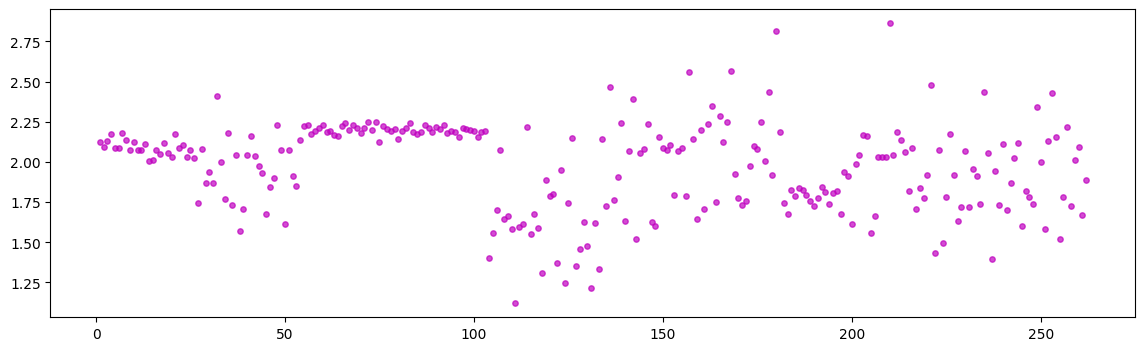

In [97]:
np.random.seed(42)

# generate data
segment_lengths = [25, 30, 48, 30, 50, 13, 66]
segment_means = [2.1, 2, 2.2, 1.6, 2, 1.8, 1.9]
# segment_means = [2.1] * 7
segment_stds = [0.05, 0.22, 0.03, 0.25, 0.3, 0.05, 0.25]
data_x, data_r, _, data_cp = generate_data(
    segment_lengths,
    segment_means,
    segment_stds
    )
num_steps = sum(segment_lengths)

plt.figure(figsize=(14, 4))
plt.scatter(np.arange(1, num_steps + 1), data_x, c='m', s=15, alpha=0.7)
plt.show()

In [98]:
# hyperparameters
mu_prior = 2.1 # rough mean
kappa_prior = 1 # keep kappa_0 small (1~5) so mu_t can track data quickly
alpha_prior = 25.0 # (2 * alpha) about 5-10x smallest segment length to expect
beta_prior = alpha_prior * (0.05**2) # beta/alpha about sigma^2 of first segment
hyper_param_rt = [hyper_param_inst(mu_prior, kappa_prior, alpha_prior, beta_prior)] # list, corresponding to different r

# keep a copy of prior to be appended to hyperparameter list
prior_hyper_param = hyper_param_inst(mu_prior, kappa_prior, alpha_prior, beta_prior)

post_rt, hist_len_rt_after_pruning = cp_detection(
    data_x,
    num_steps,
    hyper_param_rt,
    prior_hyper_param,
    var_obs=None,
    inv_hazard=20.,
    pruning_eps=1e-8,
    use_prior_for_cp=True,
    )

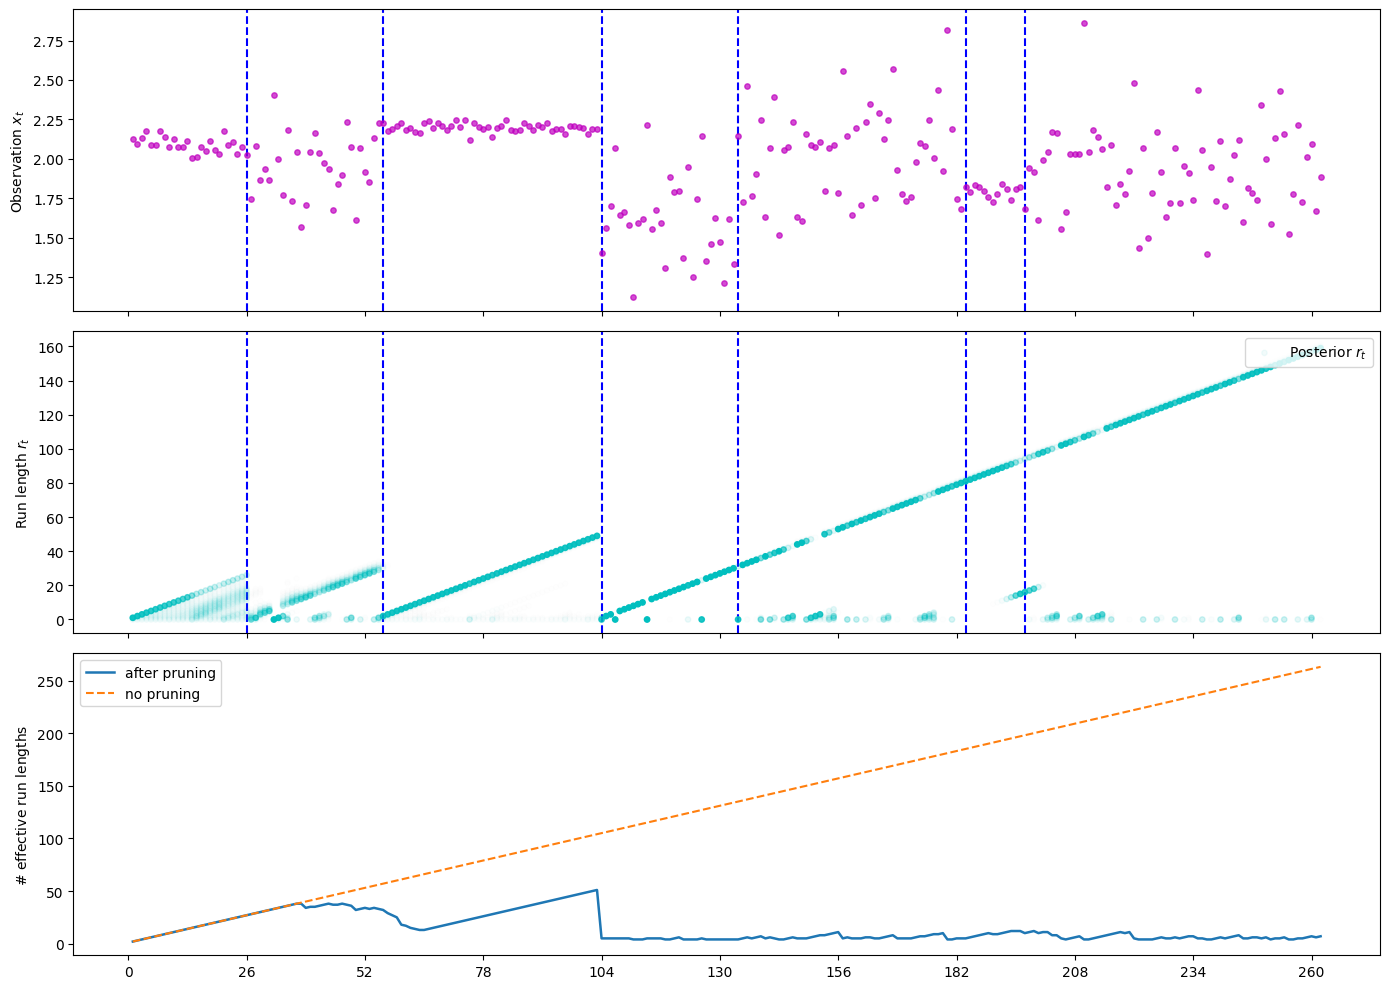

In [99]:
# print(np.argmax(post_rt[1:], axis=1))
plot_cp_detection(data_x, post_rt, hist_len_rt_after_pruning,
                   change_points=data_cp, r_true=data_r)